In [ ]:
import numpy as np
import pandas as pd
import re

In [ ]:
data='./train.csv'
df=pd.read_csv(data)
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train=df.drop(['textID','text'],axis=1)

## Data Prepocessing
#### Clean missing values , convert to lowercase , remove hashes newlines single quotes etc

In [ ]:
train.selected_text.fillna('No text',inplace=True)

In [ ]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+','', text) #remove mentions
    text = re.sub(r'#','', text) #remove hash
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub('\s+', ' ', text) #remove new line char
    text = re.sub("\'", "", text) #remove single quotes

    return text

In [ ]:
train["selected_text"]=train["selected_text"].apply(cleantext)

In [ ]:
train['selected_text'].head(7)

0                  I`d have responded, if I were going
1                                             Sooo SAD
2                                          bullying me
3                                       leave me alone
4                                        Sons of ****,
5     - some shameless plugging for the best Ranger...
6                                                  fun
Name: selected_text, dtype: object

In [ ]:
import string
train["selected_text"] = train["selected_text"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])

In [ ]:
train["selected_text"] = train["selected_text"].apply(lambda wrd: ''.join(wrd))

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train["selected_text"][:50] = train["selected_text"][:50].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))

In [ ]:
import gensim
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
from nltk.tokenize.treebank import TreebankWordTokenizer
def detokenize(text):
  return TreebankWordTokenizer().detokenize(text)

In [ ]:
temp=[]
data_to_list=train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
  temp.append(data_to_list[i])
data_wordslem=list(sent_to_words(temp))

In [ ]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
for i in range(len(data_wordslem)):
    for j in range(len(data_wordslem[i])):
        data_wordslem[i][j] = lemmatizer.lemmatize(data_wordslem[i][j],pos="v")

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detokenize(text):
  return TreebankWordDetokenizer().detokenize(text) # Use TreebankWordDetokenizer instead of TreebankWordTokenizer

data = []
for i in range(len(data_wordslem)):
    data.append(detokenize(data_wordslem[i]))
print(data[:5])

['id respond go', 'sooo sad', 'bully', 'leave alone', 'sons']


## Building a Model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

#### Tokenizing and adding padding

In [ ]:
max_words=5000
max_len=200

tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences=tokenizer.texts_to_sequences(data)
tweets=pad_sequences(sequences,maxlen=max_len)
print(tweets)

[[   0    0    0 ...  290 1026   15]
 [   0    0    0 ...    0  399   64]
 [   0    0    0 ...    0    0 3103]
 ...
 [   0    0    0 ...  379   12    5]
 [   0    0    0 ...    1  533    8]
 [   0    0    0 ...  548  196  398]]


In [ ]:
from keras.layers import Embedding
embedding_layer=Embedding(1000,64)

#### Using RNN & LSTM

In [ ]:
from keras.models import Sequential
from keras import layers

model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))

In [ ]:
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Label Encoding of output

In [ ]:
import tensorflow as tf
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
history = model2.fit(x = tweets, y= labels, epochs=25,validation_split=0.2)

Epoch 1/25
687/687 [==============================] - 42s 54ms/step - loss: 0.7033 - accuracy: 0.7040 - val_loss: 0.5091 - val_accuracy: 0.8112
Epoch 2/25
687/687 [==============================] - 17s 25ms/step - loss: 0.4567 - accuracy: 0.8284 - val_loss: 0.4664 - val_accuracy: 0.8266
Epoch 3/25
687/687 [==============================] - 15s 21ms/step - loss: 0.3943 - accuracy: 0.8544 - val_loss: 0.4443 - val_accuracy: 0.8337
Epoch 4/25
687/687 [==============================] - 14s 20ms/step - loss: 0.3588 - accuracy: 0.8695 - val_loss: 0.4348 - val_accuracy: 0.8394
Epoch 5/25
687/687 [==============================] - 16s 23ms/step - loss: 0.3367 - accuracy: 0.8757 - val_loss: 0.4388 - val_accuracy: 0.8374
Epoch 6/25
687/687 [==============================] - 15s 22ms/step - loss: 0.3202 - accuracy: 0.8819 - val_loss: 0.4392 - val_accuracy: 0.8386
Epoch 7/25
687/687 [==============================] - 15s 22ms/step - loss: 0.3032 - accuracy: 0.8890 - val_loss: 0.4513 - val_accuracy:

#### Visualizing

In [ ]:
import matplotlib.pyplot as plt

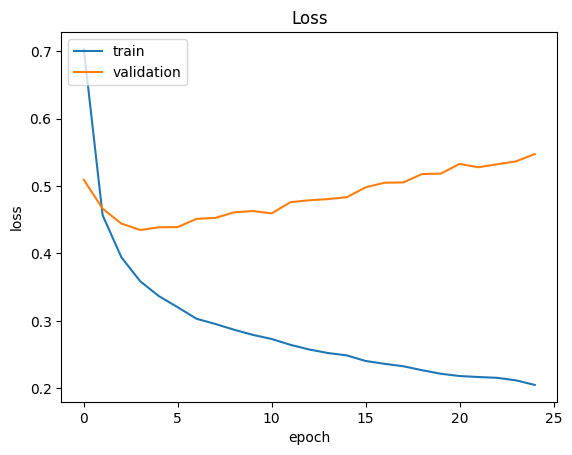

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

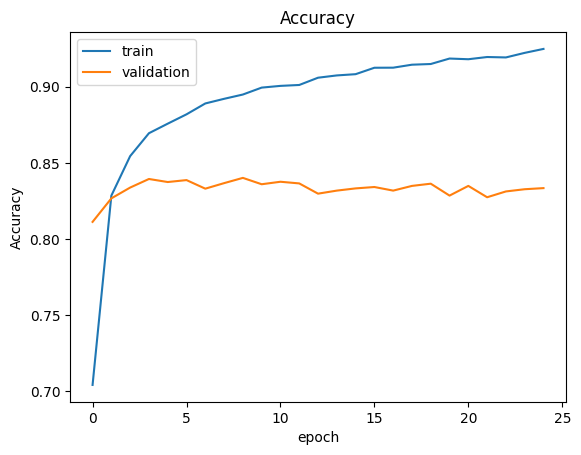

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction and result

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
def predict(text):
  sequence = tokenizer.texts_to_sequences([text])
  test = pad_sequences(sequence, maxlen=max_len)
  return sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
ans=predict('this experience has been the worst, very bad product')
print(ans)

1/1 [==============================] - 1s 743ms/step
Negative


In [ ]:
print(predict('i love sayabidevs'))

1/1 [==============================] - 0s 23ms/step
Positive


In [ ]:
import joblib
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Assuming your model is stored in a variable named `model2`
# Save the tokenizer and the model
joblib.dump(tokenizer, 'tokenizer.pkl')
model2.save('model.h5')

# If you need to save other objects, do so here
# joblib.dump(some_other_object, 'some_other_object.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
